In [1]:
import pymysql
pymysql.install_as_MySQLdb()
import pyodbc
import sqlalchemy
import MySQLdb
from sqlalchemy import create_engine
import mysql.connector
import pandas as pd
import math
from scipy.stats import norm
import scipy
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# 1. Data Cleaning and Quality Assurance
Please kindly see the SQL file

# 2. Referral program AB Testing
This is about an AB Testing of which the goal is to increase referrals by sending the $50 cash reward to users and receivers if senders refer other friends within 30-day window and finnaly the receiver gets a quote.

There are two variations we want to test. The first is Rewards amount (ctrl=25, test=50). Another is the Promotion starting time (0/2/7 Days after buying our policy)

Notes:
* A referral is defined by the receiver creating an account
* \\$25 cash reward: never received Promo email & referral created an account and got a quote at any time.
* \\$50 cash reward: received Promo email & referral created an account within 30-day window and finally get a quote at any time

In [2]:
# Define metrics
# Primary metrics: account/sender (Refer%)
# Second metrics: quote/account (Quote%_relative), policy/quote (Policy%_relative), 
#                 quote/sender (Quote%), policy/sender (Policy%)
KPIs=[
    ('sender', 'account'),
    ('account', 'quote'),
    ('quote', 'policy'),
    ('sender', 'quote'),
    ('sender', 'policy')
]

In [3]:
# Connect with MySQL
username = 'xxx'
password = 'xxx'
engine = create_engine('mysql://'+username+':'+password + '@localhost:3306')

mydb = mysql.connector.connect(
  host="localhost",
  user=username,
  passwd=password,
  database="root"
)

mycursor = mydb.cursor()

### a. Rewards Amount Test

* 0hr: (\\$25 vs. \\$50)

In [4]:
# control group: users who are in the 'off' bucket and any referrals created within 30 days
# variation group: users who are in the '0hr' bucket and any referrals created within 30 days

sql = """
WITH cte AS (
    SELECT * FROM root.joined_promo_test_transformed
    WHERE bucket IN ('off', '0hr') AND (receiver_account IS NULL OR (
    receiver_account_timestamp BETWEEN bucket_timestamp AND DATE_ADD(bucket_timestamp, INTERVAL 30 DAY))
    )
    )
SELECT bucket, 
    COUNT(DISTINCT user_id) AS sender,
    SUM(CASE WHEN receiver_account = 1 THEN 1 ELSE 0 END) AS account, 
    SUM(CASE WHEN receiver_quote = 1 THEN 1 ELSE 0 END) AS quote,
    SUM(CASE WHEN receiver_policy = 1 THEN 1 ELSE 0 END) AS policy
FROM cte
GROUP BY bucket;
"""
df_Result = pd.read_sql(sql, engine)

In [5]:
df_Result

,bucket,sender,account,quote,policy
0,0hr,851,263.0,99.0,31.0
1,off,909,167.0,58.0,15.0


In [6]:
# Adjust the order of control and variation group
df_Result.index = [1,0]
df_Result = df_Result.sort_index()

In [7]:
df_Result

,bucket,sender,account,quote,policy
0,off,909,167.0,58.0,15.0
1,0hr,851,263.0,99.0,31.0


In [8]:
def z_test_calculator(df,denominator,numerator):
    
#   INPUT:
#        df: dataframe with aggregated data
#        denominator: str
#        numerator: str

#   OUTPUT: 
#        (denominator, numerator, p_value, pct_lift, abs_lift)

    # get data
    nume_ctrl = df.loc[0, numerator]
    deno_ctrl = df.loc[0, denominator]
    nume_var = df.loc[1, numerator]
    deno_var = df.loc[1, denominator]


    # ratio
    p_ctrl = nume_ctrl / deno_ctrl
    p_var  = nume_var / deno_var

    # STD
    std_ctrl = math.sqrt(p_ctrl * (1 - p_ctrl) / deno_ctrl)
    std_var = math.sqrt(p_var * (1 - p_var) / deno_var)

    # Z-Score
    z = (p_ctrl - p_var) / math.sqrt(std_ctrl**2 + std_var**2)

    # Confident Level (1-P Value)
    cl = 1-norm.sf(abs(z))

    # Lift
    ctrl_ratio = p_ctrl
    var_ratio = p_var
    abs_lift = p_var - p_ctrl
    pct_lift = abs_lift / p_ctrl
    
    return denominator, numerator, cl, ctrl_ratio, var_ratio, pct_lift, abs_lift

In [9]:
# calculate statistical measures
dic_final = {}
for i in df_Result.index:
    if i != 0:
        test_group_n = df_Result.loc[[0, i],]
        test_group_n.index = [0,1]

        groupN_statistics = []
        for deno, nume in KPIs:
            groupN_statistics.append(z_test_calculator(test_group_n, deno, nume))
        key = 'Amount Test 0hr 2550'
        dic_final[key] = pd.DataFrame.from_records(groupN_statistics, columns = ['denominator','numerator',
                                                                                 'confident_level','ctrl_ratio','var_ratio',
                                                                                 'perc_lift','abs_lift'])
print(dic_final)

{'Amount Test 0hr 2550':   denominator numerator  confident_level  ctrl_ratio  var_ratio  perc_lift  \
0      sender   account         1.000000    0.183718   0.309048   0.682184   
1     account     quote         0.730368    0.347305   0.376426   0.083847   
2       quote    policy         0.769279    0.258621   0.313131   0.210774   
3      sender     quote         0.999940    0.063806   0.116334   0.823230   
4      sender    policy         0.995228    0.016502   0.036428   1.207521   

   abs_lift  
0  0.125330  
1  0.029120  
2  0.054511  
3  0.052527  
4  0.019926  }


In [10]:
##output to csv
writer = pd.ExcelWriter('Amount Test 0hr 2550.xlsx')
for key in dic_final.keys():
    dic_final[key].to_excel(writer, sheet_name=key)
writer.save()


* 48hr: (\\$25 vs. \\$50)

In [11]:
# control group: users who are in the 'off' bucket and any referrals created account within 2 and 32 days
# variation group: users who are in the '48hr' bucket and any referrals created account within 30 days after test start (within 2 and 32 days)

sql = """
WITH cte AS (
    SELECT * 
    FROM root.joined_promo_test_transformed
    WHERE bucket IN ('off', '48hr') 
    AND (receiver_account IS NULL 
    OR (
        receiver_account_timestamp BETWEEN DATE_ADD(bucket_timestamp, INTERVAL 2 DAY) 
        AND 
        DATE_ADD(bucket_timestamp, INTERVAL 32 DAY))
        )
    )
SELECT bucket, 
    COUNT(DISTINCT user_id) AS sender,
    SUM(CASE WHEN receiver_account = 1 THEN 1 ELSE 0 END) AS account, 
    SUM(CASE WHEN receiver_quote = 1 THEN 1 ELSE 0 END) AS quote,
    SUM(CASE WHEN receiver_policy = 1 THEN 1 ELSE 0 END) AS policy
FROM cte
GROUP BY bucket;
"""

df_Result = pd.read_sql(sql, engine)

In [12]:
df_Result

,bucket,sender,account,quote,policy
0,48hr,812,146.0,47.0,16.0
1,off,866,102.0,34.0,8.0


In [13]:
df_Result.index = [1,0]
df_Result = df_Result.sort_index()

In [14]:
df_Result

,bucket,sender,account,quote,policy
0,off,866,102.0,34.0,8.0
1,48hr,812,146.0,47.0,16.0


In [15]:
dic_final = {}
for i in df_Result.index:
    if i != 0:
        test_group_n = df_Result.loc[[0, i],]
        test_group_n.index = [0,1]

        groupN_statistics = []
        for deno, nume in KPIs:
            groupN_statistics.append(z_test_calculator(test_group_n, deno, nume))
        key = 'Amount Test 48hr 2550'
        dic_final[key] = pd.DataFrame.from_records(groupN_statistics, columns = ['denominator','numerator',
                                                                                 'confident_level','ctrl_ratio','var_ratio',
                                                                                 'perc_lift','abs_lift'])
print(dic_final)

{'Amount Test 48hr 2550':   denominator numerator  confident_level  ctrl_ratio  var_ratio  perc_lift  \
0      sender   account         0.999822    0.117783   0.179803   0.526562   
1     account     quote         0.574695    0.333333   0.321918  -0.034247   
2       quote    policy         0.852608    0.235294   0.340426   0.446809   
3      sender     quote         0.961611    0.039261   0.057882   0.474283   
4      sender    policy         0.962922    0.009238   0.019704   1.133005   

   abs_lift  
0  0.062020  
1 -0.011416  
2  0.105131  
3  0.018621  
4  0.010467  }


In [16]:
##output to csv
writer = pd.ExcelWriter('Amount Test 48hr 2550.xlsx')
for key in dic_final.keys():
    dic_final[key].to_excel(writer, sheet_name=key)
writer.save()


* 168hr: (\\$25 vs. \\$50)

In [17]:
# control group: users who are in the 'off' bucket and any referrals created account within 7 and 37 days
# variation group: users who are in the '168hr' bucket and any referrals created account within 30 days after test start (within 7 and 37 days)

sql = """
WITH cte AS (
    SELECT * 
    FROM root.joined_promo_test_transformed
    WHERE bucket IN ('off', '168hr') 
    AND (receiver_account IS NULL 
    OR (
        receiver_account_timestamp BETWEEN DATE_ADD(bucket_timestamp, INTERVAL 7 DAY) 
        AND 
        DATE_ADD(bucket_timestamp, INTERVAL 37 DAY))
        )
    )
SELECT bucket, 
    COUNT(DISTINCT user_id) AS sender,
    SUM(CASE WHEN receiver_account = 1 THEN 1 ELSE 0 END) AS account, 
    SUM(CASE WHEN receiver_quote = 1 THEN 1 ELSE 0 END) AS quote,
    SUM(CASE WHEN receiver_policy = 1 THEN 1 ELSE 0 END) AS policy
FROM cte
GROUP BY bucket;

"""

df_Result = pd.read_sql(sql, engine)

In [18]:
df_Result

,bucket,sender,account,quote,policy
0,168hr,705,116.0,36.0,8.0
1,off,847,76.0,26.0,7.0


In [19]:
df_Result.index = [1,0]
df_Result = df_Result.sort_index()

In [20]:
df_Result

,bucket,sender,account,quote,policy
0,off,847,76.0,26.0,7.0
1,168hr,705,116.0,36.0,8.0


In [21]:
dic_final = {}
for i in df_Result.index:
    if i != 0:
        test_group_n = df_Result.loc[[0, i],]
        test_group_n.index = [0,1]

        groupN_statistics = []
        for deno, nume in KPIs:
            groupN_statistics.append(z_test_calculator(test_group_n, deno, nume))
        key = 'Amount Test 168hr 2550'.format(i)
        dic_final[key] = pd.DataFrame.from_records(groupN_statistics, columns = ['denominator','numerator',
                                                                                 'confident_level','ctrl_ratio','var_ratio',
                                                                                 'perc_lift','abs_lift'])
print(dic_final)

{'Amount Test 168hr 2550':   denominator numerator  confident_level  ctrl_ratio  var_ratio  perc_lift  \
0      sender   account         0.999994    0.089728   0.164539   0.833744   
1     account     quote         0.676564    0.342105   0.310345  -0.092838   
2       quote    policy         0.663740    0.269231   0.222222  -0.174603   
3      sender     quote         0.977169    0.030697   0.051064   0.663502   
4      sender    policy         0.728891    0.008264   0.011348   0.373050   

   abs_lift  
0  0.074811  
1 -0.031760  
2 -0.047009  
3  0.020367  
4  0.003083  }


In [22]:
##output to csv
writer = pd.ExcelWriter('Amount Test 168hr 2550.xlsx')
for key in dic_final.keys():
    dic_final[key].to_excel(writer, sheet_name=key)
writer.save()

### b. Promotion Time
\\$50:  (0 / 2 / 7 days)

In [23]:
# Users who are in '0hr, 48hr, 168hr' bucket and any referrals created within 30-days window respectively.

sql = """
WITH cte AS (
    SELECT * 
    FROM root.joined_promo_test_transformed
    WHERE bucket <> 'off' AND (receiver_account IS NULL OR (receiver_account_timestamp BETWEEN `start` AND `end`))
    )
SELECT bucket, 
    COUNT(DISTINCT user_id) AS sender,
    SUM(CASE WHEN receiver_account = 1 THEN 1 ELSE 0 END) AS account, 
    SUM(CASE WHEN receiver_quote = 1 THEN 1 ELSE 0 END) AS quote,
    SUM(CASE WHEN receiver_policy = 1 THEN 1 ELSE 0 END) AS policy
FROM cte
GROUP BY bucket;
"""
df_Result = pd.read_sql(sql, engine)

In [24]:
df_Result

,bucket,sender,account,quote,policy
0,0hr,851,263.0,99.0,31.0
1,168hr,705,116.0,36.0,8.0
2,48hr,812,146.0,47.0,16.0


In [25]:
# Always put control group records in the line with index=0
df_Result.index = [0,2,1]
df_Result = df_Result.sort_index()

In [26]:
df_Result

,bucket,sender,account,quote,policy
0,0hr,851,263.0,99.0,31.0
1,48hr,812,146.0,47.0,16.0
2,168hr,705,116.0,36.0,8.0


In [27]:
#  Calulate statistical measures
dic_final = {}
for i in df_Result.index:
    if i != 0:
        test_group_n = df_Result.loc[[0, i],]
        test_group_n.index = [0,1]

        groupN_statistics = []
        for deno, nume in KPIs:
            groupN_statistics.append(z_test_calculator(test_group_n, deno, nume))
        key = 'Promo Time Test {}  50 027d'.format(i)
        dic_final[key] = pd.DataFrame.from_records(groupN_statistics, columns = ['denominator','numerator',
                                                                                 'confident_level','ctrl_ratio','var_ratio',
                                                                                 'perc_lift','abs_lift'])
print(dic_final)

{'Promo Time Test 1  50 027d':   denominator numerator  confident_level  ctrl_ratio  var_ratio  perc_lift  \
0      sender   account         1.000000    0.309048   0.179803  -0.418204   
1     account     quote         0.867686    0.376426   0.321918  -0.144804   
2       quote    policy         0.628318    0.313131   0.340426   0.087165   
3      sender     quote         0.999990    0.116334   0.057882  -0.502451   
4      sender    policy         0.980947    0.036428   0.019704  -0.459082   

   abs_lift  
0 -0.129245  
1 -0.054508  
2  0.027294  
3 -0.058452  
4 -0.016723  , 'Promo Time Test 2  50 027d':   denominator numerator  confident_level  ctrl_ratio  var_ratio  perc_lift  \
0      sender   account         1.000000    0.309048   0.164539  -0.467594   
1     account     quote         0.896699    0.376426   0.310345  -0.175549   
2       quote    policy         0.861840    0.313131   0.222222  -0.290323   
3      sender     quote         0.999999    0.116334   0.051064  -0.56105

In [28]:
## output to csv
writer = pd.ExcelWriter('Promo Time Test 50 027d.xlsx')
for key in dic_final.keys():
    dic_final[key].to_excel(writer, sheet_name=key)
writer.save()

### c. Combined Impact: amount and time impact

In [29]:
# Compare the combined impact ($50 & Promo starts 2 days after buying a policy)

sql = """
SELECT bucket, 
    COUNT(DISTINCT user_id) AS sender,
    SUM(CASE WHEN receiver_account = 1 THEN 1 ELSE 0 END) AS account, 
    SUM(CASE WHEN receiver_quote = 1 THEN 1 ELSE 0 END) AS quote,
    SUM(CASE WHEN receiver_policy = 1 THEN 1 ELSE 0 END) AS policy
FROM (
    SELECT *
    FROM root.joined_promo_test_transformed
    WHERE bucket = 'off' 
    AND (receiver_account IS NULL OR (receiver_account_timestamp BETWEEN bucket_timestamp AND DATE_ADD(bucket_timestamp, INTERVAL 30 DAY)))
    ) sub1
GROUP BY bucket
UNION
SELECT bucket, 
    COUNT(DISTINCT user_id) AS sender,
    SUM(CASE WHEN receiver_account = 1 THEN 1 ELSE 0 END) AS account, 
    SUM(CASE WHEN receiver_quote = 1 THEN 1 ELSE 0 END) AS quote,
    SUM(CASE WHEN receiver_policy = 1 THEN 1 ELSE 0 END) AS policy
FROM (
    SELECT *
    FROM root.joined_promo_test_transformed
    WHERE bucket = '48hr' 
    AND (receiver_account IS NULL OR (receiver_account_timestamp BETWEEN DATE_ADD(bucket_timestamp, INTERVAL 2 DAY) AND DATE_ADD(bucket_timestamp, INTERVAL 32 DAY)))
    ) sub2
GROUP BY bucket;
"""

df_Result = pd.read_sql(sql, engine)

In [30]:
df_Result

,bucket,sender,account,quote,policy
0,off,909,167.0,58.0,15.0
1,48hr,812,146.0,47.0,16.0


In [31]:
# Calulate statistical measures
dic_final = {}
for i in df_Result.index:
    if i != 0:
        test_group_n = df_Result.loc[[0, i],]
        test_group_n.index = [0,1]

        groupN_statistics = []
        for deno, nume in KPIs:
            groupN_statistics.append(z_test_calculator(test_group_n, deno, nume))
        key = 'Comb impact 50 48hr vs 25 0hr'
        dic_final[key] = pd.DataFrame.from_records(groupN_statistics, columns = ['denominator','numerator',
                                                                                 'confident_level','ctrl_ratio','var_ratio',
                                                                                 'perc_lift','abs_lift'])
print(dic_final)

{'Comb impact 50 48hr vs 25 0hr':   denominator numerator  confident_level  ctrl_ratio  var_ratio  perc_lift  \
0      sender   account         0.583288    0.183718   0.179803  -0.021312   
1     account     quote         0.682729    0.347305   0.321918  -0.073099   
2       quote    policy         0.818560    0.258621   0.340426   0.316312   
3      sender     quote         0.696365    0.063806   0.057882  -0.092853   
4      sender    policy         0.690165    0.016502   0.019704   0.194089   

   abs_lift  
0 -0.003915  
1 -0.025388  
2  0.081805  
3 -0.005925  
4  0.003203  }


In [32]:
## output to csv
writer = pd.ExcelWriter('Comb impact 50 48hr vs 25 0hr.xlsx')
for key in dic_final.keys():
    dic_final[key].to_excel(writer, sheet_name=key)
writer.save()

In [33]:
# Compare the combined impact ($50 & Promo starts 7 days after buying a policy)
sql = """
SELECT bucket, 
    COUNT(DISTINCT user_id) AS sender,
    SUM(CASE WHEN receiver_account = 1 THEN 1 ELSE 0 END) AS account, 
    SUM(CASE WHEN receiver_quote = 1 THEN 1 ELSE 0 END) AS quote,
    SUM(CASE WHEN receiver_policy = 1 THEN 1 ELSE 0 END) AS policy
FROM (
    SELECT *
    FROM root.joined_promo_test_transformed
    WHERE bucket = 'off' 
    AND (receiver_account IS NULL OR (receiver_account_timestamp BETWEEN bucket_timestamp AND DATE_ADD(bucket_timestamp, INTERVAL 30 DAY)))
    ) sub1
GROUP BY bucket
UNION
SELECT bucket, 
    COUNT(DISTINCT user_id) AS sender,
    SUM(CASE WHEN receiver_account = 1 THEN 1 ELSE 0 END) AS account, 
    SUM(CASE WHEN receiver_quote = 1 THEN 1 ELSE 0 END) AS quote,
    SUM(CASE WHEN receiver_policy = 1 THEN 1 ELSE 0 END) AS policy
FROM (
    SELECT *
    FROM root.joined_promo_test_transformed
    WHERE bucket = '168hr' 
    AND (receiver_account IS NULL OR (receiver_account_timestamp BETWEEN DATE_ADD(bucket_timestamp, INTERVAL 7 DAY) AND DATE_ADD(bucket_timestamp, INTERVAL 37 DAY)))
    ) sub2
GROUP BY bucket;
"""

df_Result = pd.read_sql(sql, engine)

In [34]:
df_Result

,bucket,sender,account,quote,policy
0,off,909,167.0,58.0,15.0
1,168hr,705,116.0,36.0,8.0


In [35]:
# Calulate statistical measures
dic_final = {}
for i in df_Result.index:
    if i != 0:
        test_group_n = df_Result.loc[[0, i],]
        test_group_n.index = [0,1]

        groupN_statistics = []
        for deno, nume in KPIs:
            groupN_statistics.append(z_test_calculator(test_group_n, deno, nume))
        key = 'Comb impact 50 168hr vs 25 0hr'
        dic_final[key] = pd.DataFrame.from_records(groupN_statistics, columns = ['denominator','numerator',
                                                                                 'confident_level','ctrl_ratio','var_ratio',
                                                                                 'perc_lift','abs_lift'])
print(dic_final)

{'Comb impact 50 168hr vs 25 0hr':   denominator numerator  confident_level  ctrl_ratio  var_ratio  perc_lift  \
0      sender   account         0.843965    0.183718   0.164539  -0.104395   
1     account     quote         0.743162    0.347305   0.310345  -0.106421   
2       quote    policy         0.656988    0.258621   0.222222  -0.140741   
3      sender     quote         0.864106    0.063806   0.051064  -0.199707   
4      sender    policy         0.812452    0.016502   0.011348  -0.312340   

   abs_lift  
0 -0.019179  
1 -0.036961  
2 -0.036398  
3 -0.012743  
4 -0.005154  }


In [36]:
##output to csv
writer = pd.ExcelWriter('Comb impact 50 168hr vs 25 0hr.xlsx')
for key in dic_final.keys():
    dic_final[key].to_excel(writer, sheet_name=key)
writer.save()

# 3. Analyze the performance of each test group
For the rest of analysis and presentation, please see the PowerPoint Attached

In [37]:
# ROI analysis and Total Revenue 
sql = """
-- off
WITH rev_ctrl AS
(SELECT COUNT(*) * 600 AS total_revenue
FROM root.joined_promo_test_transformed
WHERE bucket = 'off' AND receiver_policy=1 AND (receiver_account_timestamp BETWEEN bucket_timestamp AND DATE_ADD(bucket_timestamp, INTERVAL 30 DAY))),
cost_ctrl AS (
SELECT SUM(IFNULL(sender_earned_amount_in_dollars, 0) + IFNULL(receiver_earned_amount_in_dollars,0)) AS total_cost
FROM root.joined_promo_test_transformed
WHERE bucket = 'off' AND (receiver_account_timestamp BETWEEN bucket_timestamp AND DATE_ADD(bucket_timestamp, INTERVAL 30 DAY))),
rev_0hr AS
(SELECT COUNT(*) * 600 AS total_revenue
FROM root.joined_promo_test_transformed
WHERE bucket = '0hr' AND receiver_policy=1 AND (receiver_account_timestamp BETWEEN bucket_timestamp AND DATE_ADD(bucket_timestamp, INTERVAL 30 DAY))),
cost_0hr AS (
SELECT SUM(IFNULL(sender_earned_amount_in_dollars, 0) + IFNULL(receiver_earned_amount_in_dollars,0)) AS total_cost
FROM root.joined_promo_test_transformed
WHERE bucket = '0hr' AND (receiver_account_timestamp BETWEEN bucket_timestamp AND DATE_ADD(bucket_timestamp, INTERVAL 30 DAY))),

rev_48hr AS
(SELECT COUNT(*) * 600 AS total_revenue
FROM root.joined_promo_test_transformed
WHERE bucket = '48hr' AND receiver_policy=1 AND (receiver_account_timestamp BETWEEN DATE_ADD(bucket_timestamp, INTERVAL 2 DAY) AND DATE_ADD(bucket_timestamp, INTERVAL 32 DAY))),
cost_48hr AS (
SELECT SUM(IFNULL(sender_earned_amount_in_dollars, 0) + IFNULL(receiver_earned_amount_in_dollars,0)) AS total_cost
FROM root.joined_promo_test_transformed
WHERE bucket = '48hr' AND (receiver_account_timestamp BETWEEN DATE_ADD(bucket_timestamp, INTERVAL 2 DAY) AND DATE_ADD(bucket_timestamp, INTERVAL 32 DAY))),

rev_168hr AS
(SELECT COUNT(*) * 600 AS total_revenue
FROM root.joined_promo_test_transformed
WHERE bucket = '168hr' AND receiver_policy=1 AND (receiver_account_timestamp BETWEEN DATE_ADD(bucket_timestamp, INTERVAL 7 DAY) AND DATE_ADD(bucket_timestamp, INTERVAL 30 DAY))),
cost_168hr AS (
SELECT SUM(IFNULL(sender_earned_amount_in_dollars, 0) + IFNULL(receiver_earned_amount_in_dollars,0)) AS total_cost
FROM root.joined_promo_test_transformed
WHERE bucket = '168hr' AND (receiver_account_timestamp BETWEEN DATE_ADD(bucket_timestamp, INTERVAL 7 DAY) AND DATE_ADD(bucket_timestamp, INTERVAL 30 DAY)))

SELECT 'ctrl' AS bucket,rev_ctrl.total_revenue, cost_ctrl.total_cost, total_revenue -total_cost AS total_profit, ROUND((rev_ctrl.total_revenue - cost_ctrl.total_cost)/cost_ctrl.total_cost, 2) AS ROI
FROM rev_ctrl, cost_ctrl

UNION

SELECT '0hr' AS bucket,rev_0hr.total_revenue, cost_0hr.total_cost,  total_revenue -total_cost AS total_profit,ROUND((rev_0hr.total_revenue - cost_0hr.total_cost)/cost_0hr.total_cost, 2) AS ROI
FROM rev_0hr, cost_0hr

UNION

SELECT '48hr' AS bucket,rev_48hr.total_revenue, cost_48hr.total_cost,  total_revenue -total_cost AS total_profit,ROUND((rev_48hr.total_revenue - cost_48hr.total_cost)/cost_48hr.total_cost, 2) AS ROI
FROM rev_48hr, cost_48hr

UNION

SELECT '168hr' AS bucket,rev_168hr.total_revenue, cost_168hr.total_cost, total_revenue -total_cost AS total_profit, ROUND((rev_168hr.total_revenue - cost_168hr.total_cost)/cost_168hr.total_cost, 2) AS ROI
FROM rev_168hr, cost_168hr;

"""

res = pd.read_sql(sql, engine)
res

,bucket,total_revenue,total_cost,total_profit,ROI
0,ctrl,9000,2900.0,6100.0,2.10
1,0hr,18600,9725.0,8875.0,0.91
2,48hr,9600,4600.0,5000.0,1.09
3,168hr,4800,3350.0,1450.0,0.43


In [38]:
# Other Findings:
sql = """
SELECT DATEDIFF(receiver_account_timestamp, `start`) AS days
FROM root.joined_promo_test_transformed
HAVING days>=0;
"""
res = pd.read_sql(sql, engine)

In [39]:
res.count()

days    600
dtype: int64

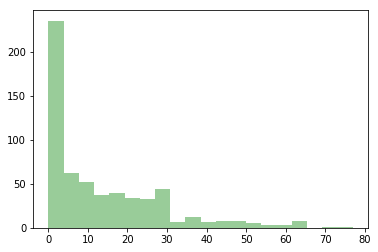

In [40]:
sns.distplot(res,hist = True,  kde=False,  bins=20, color='green')